In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [6]:
# Konstanta dan Path
BASE_DIR = 'dataset/'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# --- Path Penyimpanan Hasil ---
RESULTS_BASE_DIR = 'results'
GRAPH_BASELINE_DIR = os.path.join(RESULTS_BASE_DIR, 'graph/finetune')
MODEL_BASELINE_DIR = os.path.join(RESULTS_BASE_DIR, 'model/finetune')

# Kelas
CLASSES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
NUM_CLASSES = len(CLASSES)
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32


Menampilkan sampel gambar dari direktori training:


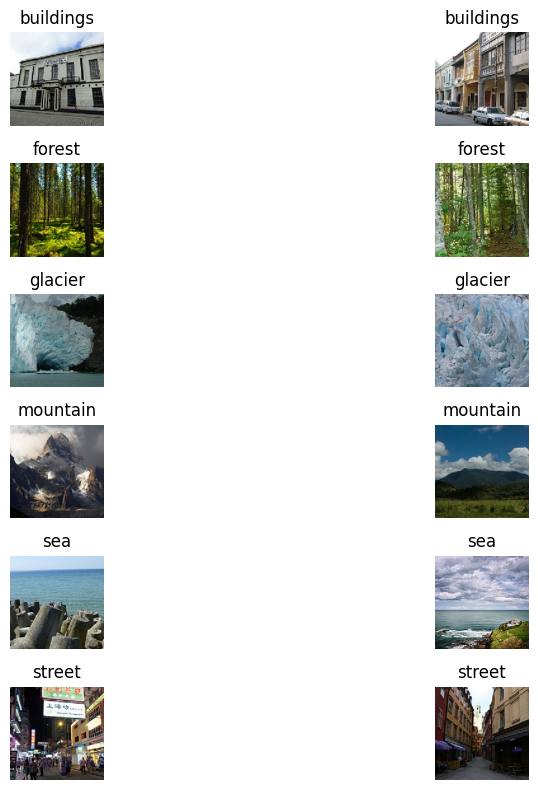

In [7]:
# Fungsi untuk menampilkan sampel gambar
def display_samples(data_dir, num_samples_per_class=2):
    plt.figure(figsize=(12, 8))
    for i, class_name in enumerate(CLASSES):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Directory tidak ditemukan - {class_path}")
            continue
        
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        if not image_files:
            print(f"Warning: Tidak ada file gambar di {class_path}")
            continue
            
        for j in range(min(num_samples_per_class, len(image_files))):
            img_path = os.path.join(class_path, np.random.choice(image_files))
            try:
                img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
                plt.subplot(NUM_CLASSES, num_samples_per_class, i * num_samples_per_class + j + 1)
                plt.imshow(img)
                plt.title(f"{class_name}")
                plt.axis('off')
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    plt.tight_layout()
    plt.show()

print("\nMenampilkan sampel gambar dari direktori training:")
display_samples(TRAIN_DIR)


Distribusi Kelas Data Training:


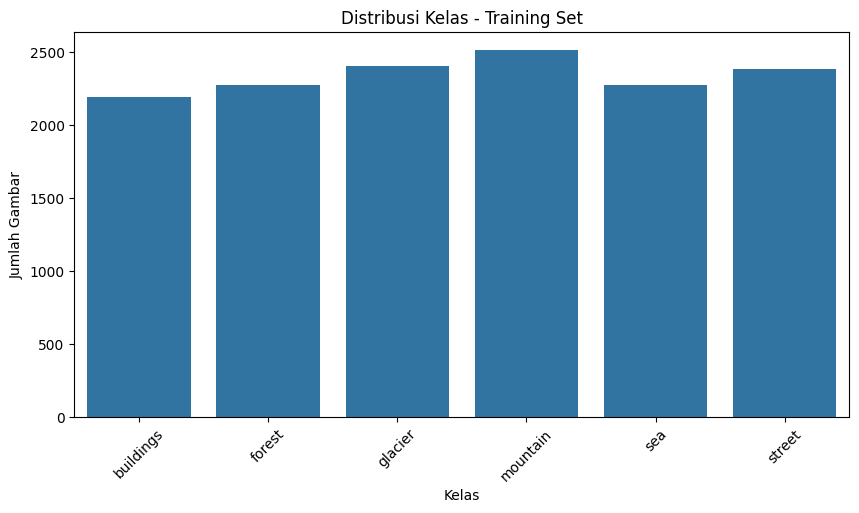

Distribusi kelas untuk Distribusi Kelas - Training Set: {'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}

Distribusi Kelas Data Testing:


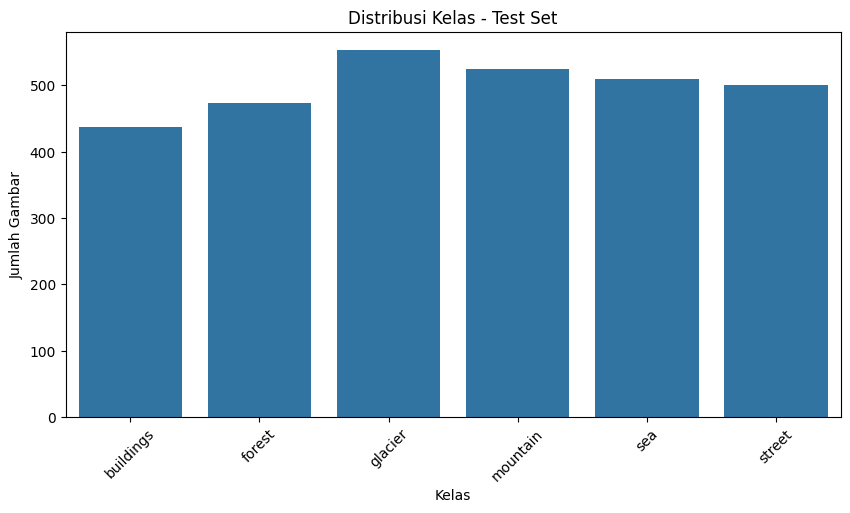

Distribusi kelas untuk Distribusi Kelas - Test Set: {'buildings': 437, 'forest': 474, 'glacier': 553, 'mountain': 525, 'sea': 510, 'street': 501}


In [8]:
# Fungsi untuk menghitung dan menampilkan distribusi kelas
def plot_class_distribution(data_dir, title):
    class_counts = {}
    for class_name in CLASSES:
        class_path = os.path.join(data_dir, class_name)
        if not os.path.exists(class_path):
            class_counts[class_name] = 0
            continue
        class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title(title)
    plt.xlabel("Kelas")
    plt.ylabel("Jumlah Gambar")
    plt.xticks(rotation=45)
    plt.show()
    print(f"Distribusi kelas untuk {title}: {class_counts}")

print("\nDistribusi Kelas Data Training:")
plot_class_distribution(TRAIN_DIR, "Distribusi Kelas - Training Set")

print("\nDistribusi Kelas Data Testing:")
plot_class_distribution(TEST_DIR, "Distribusi Kelas - Test Set")


Memulai EDA Lanjutan...

Mengumpulkan metadata gambar dari direktori training untuk EDA Lanjutan...
Mengumpulkan metadata dari: dataset/train
  Processing class: buildings (438 sampel)
  Processing class: forest (454 sampel)
  Processing class: glacier (480 sampel)
  Processing class: mountain (502 sampel)
  Processing class: sea (454 sampel)
  Processing class: street (476 sampel)


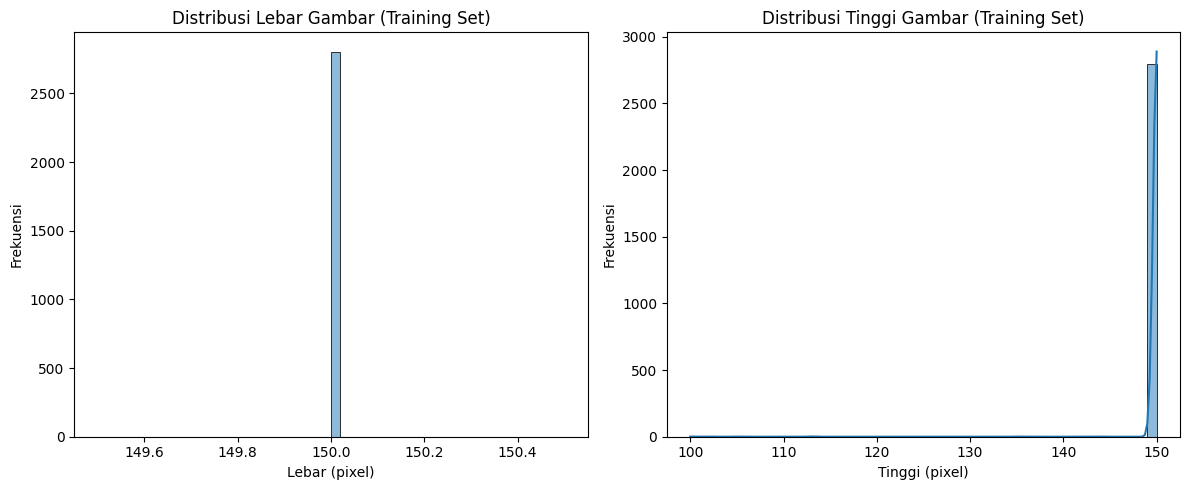


Statistik Deskriptif Dimensi Gambar (Training Set):
Lebar:
 count    2804.0
mean      150.0
std         0.0
min       150.0
25%       150.0
50%       150.0
75%       150.0
max       150.0
Name: width, dtype: float64

Tinggi:
 count    2804.000000
mean      149.910128
std         1.888938
min       100.000000
25%       150.000000
50%       150.000000
75%       150.000000
max       150.000000
Name: height, dtype: float64


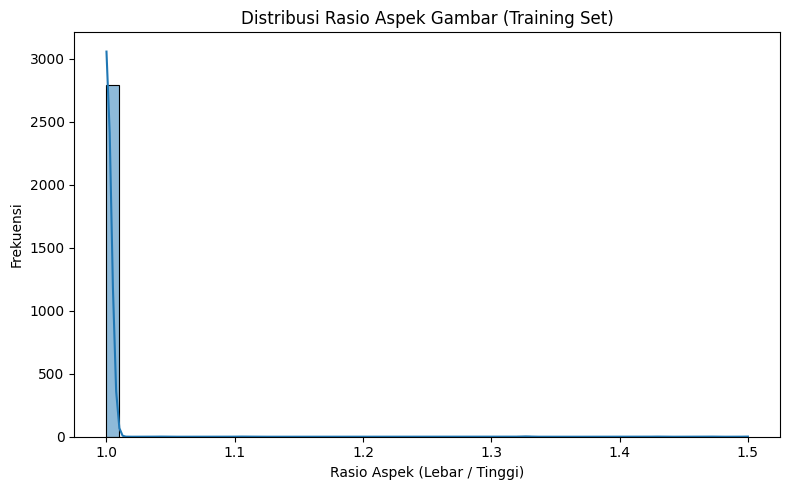


Statistik Deskriptif Rasio Aspek (Training Set):
 count    2804.000000
mean        1.000824
std         0.017842
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.500000
Name: aspect_ratio, dtype: float64


/tmp/ipykernel_544/1245277937.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Kelas')


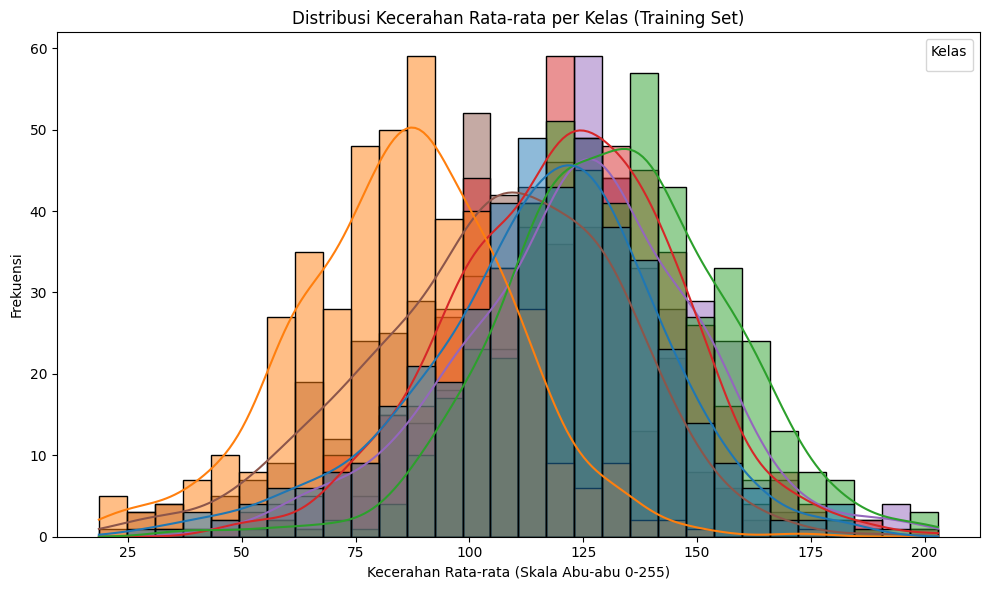

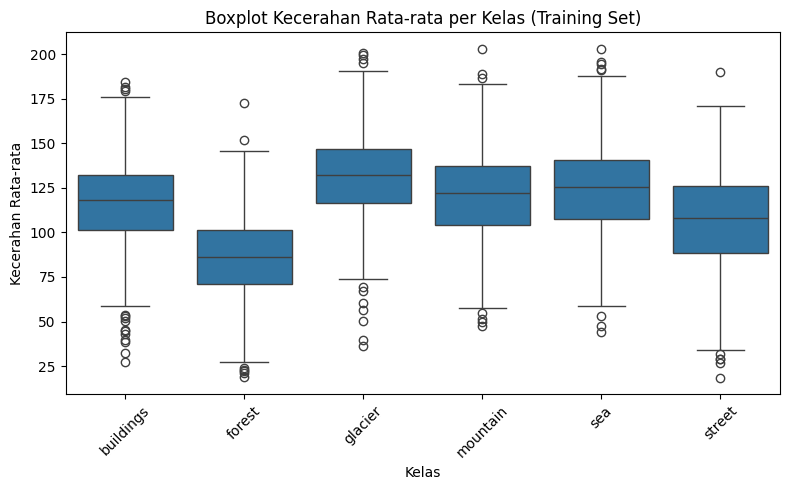


Statistik Deskriptif Kecerahan Rata-rata (Training Set):
 count    2804.000000
mean      114.036222
std        29.290681
min        18.587422
25%        95.091544
50%       116.150667
75%       133.953922
max       202.951867
Name: brightness, dtype: float64

Statistik Deskriptif Kecerahan Rata-rata per Kelas:
           count        mean        std        min         25%         50%  \
class                                                                        
buildings  438.0  115.685601  26.056080  27.408578  101.196589  118.243156   
forest     454.0   85.494405  23.117925  19.142133   70.926000   86.355533   
glacier    480.0  131.425300  24.424337  36.417378  116.311289  132.115356   
mountain   502.0  121.054323  24.378109  47.392978  104.190144  121.927889   
sea        454.0  123.520352  26.207232  44.398089  107.286922  125.399556   
street     476.0  105.758738  27.417172  18.587422   88.284256  108.175178   

                  75%         max  
class                     

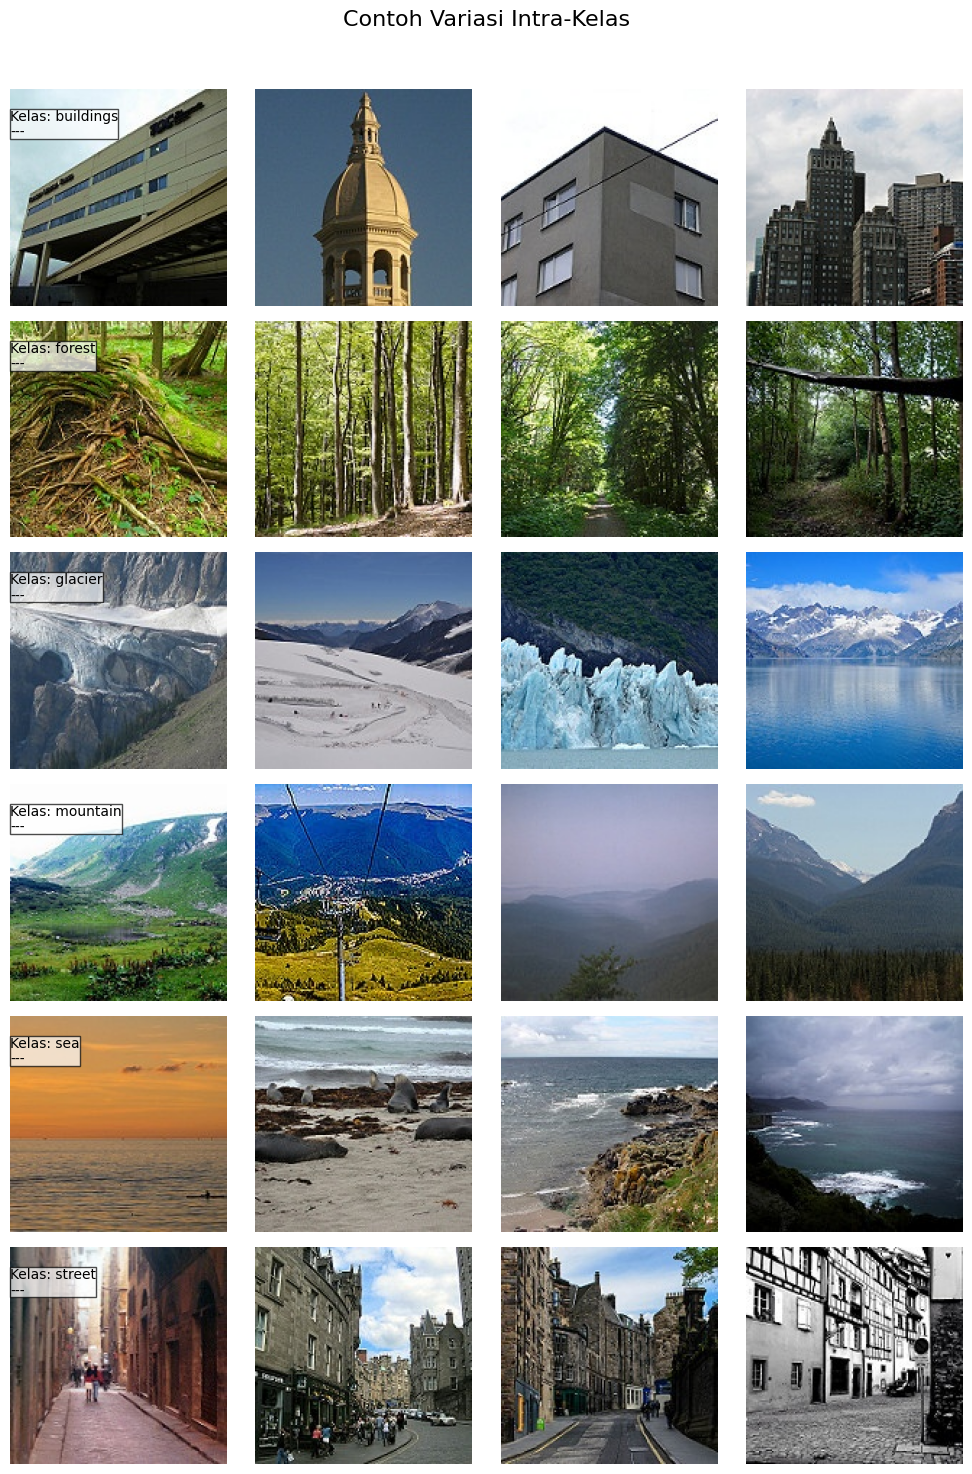


EDA Lanjutan Selesai.


In [9]:
# Fungsi untuk mengumpulkan informasi dimensi dan kecerahan
def get_image_meta_data(data_dir, sample_fraction=0.1):
    image_metadata = []
    for class_name in CLASSES:
        class_path = os.path.join(data_dir, class_name)
        if not os.path.exists(class_path):
            continue
        
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        
        if len(image_files) > 100 :
            num_samples_to_check = int(len(image_files) * sample_fraction)
            sampled_files = np.random.choice(image_files, num_samples_to_check, replace=False)
        else:
            sampled_files = image_files

        print(f"  Processing class: {class_name} ({len(sampled_files)} sampel)")
        for img_name in sampled_files:
            img_path = os.path.join(class_path, img_name)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    height, width, _ = img.shape
                    aspect_ratio = width / height
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    brightness = np.mean(gray_img)
                    image_metadata.append({
                        'class': class_name,
                        'width': width,
                        'height': height,
                        'aspect_ratio': aspect_ratio,
                        'brightness': brightness
                    })
                else:
                    print(f"    Warning: Gagal memuat gambar {img_path}")
            except Exception as e:
                print(f"    Error processing image {img_path}: {e}")
    return pd.DataFrame(image_metadata)

train_metadata_df = get_image_meta_data(TRAIN_DIR, sample_fraction=0.2)
test_metadata_df = get_image_meta_data(TEST_DIR, sample_fraction=0.2)

if not train_metadata_df.empty:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=train_metadata_df, x='brightness', hue='class', kde=True, bins=30)
    plt.title('Distribusi Kecerahan Rata-rata per Kelas (Training Set)')
    plt.xlabel('Kecerahan Rata-rata (Skala Abu-abu 0-255)')
    plt.ylabel('Frekuensi')
    plt.legend(title='Kelas')
    plt.tight_layout()
    plt.show()

In [ ]:
def display_class_variations(data_dir, num_samples_per_class=5):
    print(f"\nMenampilkan variasi dalam setiap kelas (maks {num_samples_per_class} sampel per kelas):")
    num_cols = num_samples_per_class
    num_rows = NUM_CLASSES
    
    plt.figure(figsize=(num_cols * 2.5, num_rows * 2.5))
    for i, class_name in enumerate(CLASSES):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.exists(class_path): continue
        
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        if not image_files: continue
            
        selected_files = np.random.choice(image_files, min(len(image_files), num_samples_per_class), replace=False)
        
        for j, file_name in enumerate(selected_files):
            img_path = os.path.join(class_path, file_name)
            try:
                img = load_img(img_path, target_size=(150, 150))
                plt.subplot(num_rows, num_cols, i * num_cols + j + 1)
                plt.imshow(img)
                if j == 0:
                    plt.title(f"Kelas: {class_name}\n---", loc='left', fontsize=10, y=0.8, verticalalignment='center', backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.7,pad=0))

                plt.axis('off')
            except Exception as e:
                print(f"Error loading image {img_path} untuk variasi kelas: {e}")
    plt.suptitle("Contoh Variasi Intra-Kelas", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

display_class_variations(TRAIN_DIR, num_samples_per_class=4)

In [10]:
# def apply_gaussian_blur(image):
#     if not isinstance(image, np.ndarray):
#         image = np.array(image)
#     if image.dtype != np.uint8:
#         if image.max() <= 1.0 and image.min() >=0.0:
#              image_uint8 = (image * 255).astype(np.uint8)
#         else:
#              image_uint8 = image.astype(np.uint8)
#     else:
#         image_uint8 = image
#     return cv2.GaussianBlur(image_uint8, (5, 5), 0)

In [11]:
# def apply_median_blur(image):
#     if not isinstance(image, np.ndarray):
#         image = np.array(image)
#     if image.dtype != np.uint8:
#         if image.max() <= 1.0 and image.min() >=0.0:
#              image_uint8 = (image * 255).astype(np.uint8)
#         else:
#              image_uint8 = image.astype(np.uint8)
#     else:
#         image_uint8 = image
#     return cv2.medianBlur(image_uint8, 5)

In [12]:
# def apply_histogram_equalization(image):
#     if not isinstance(image, np.ndarray):
#         image = np.array(image)
#     if image.dtype != np.uint8:
#         if image.max() <= 1.0 and image.min() >=0.0:
#              image_uint8 = (image * 255).astype(np.uint8)
#         else:
#              image_uint8 = image.astype(np.uint8)
#     else:
#         image_uint8 = image

#     if len(image_uint8.shape) == 3 and image_uint8.shape[2] == 3:
#         img_yuv = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2YUV)
#         img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
#         return cv2.cvtColor(img_yuv, cv2.YUV2BGR)
#     elif len(image_uint8.shape) == 2 or (len(image_uint8.shape) == 3 and image_uint8.shape[2] == 1):
#         return cv2.equalizeHist(image_uint8)
#     return image_uint8

In [14]:
train_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_v3_preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1 # 10% untuk validasi
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_v3_preprocess_input
    validation_split=0.1
)

# Untuk data validasi dan test, hanya lakukan pra-pemrosesan MobileNetV3
test_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_v3_preprocess_input
)

In [15]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = valid_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 12632 images belonging to 6 classes.
Found 1402 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [16]:
print(f"Jumlah kelas: {train_generator.num_classes}")
print(f"Indeks kelas: {train_generator.class_indices}")
print(f"Jumlah sampel training: {train_generator.samples}")
print(f"Jumlah sampel validasi: {validation_generator.samples}")
print(f"Jumlah sampel test: {test_generator.samples}")

Jumlah kelas: 6
Indeks kelas: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Jumlah sampel training: 12632
Jumlah sampel validasi: 1402
Jumlah sampel test: 3000


In [17]:
sample_batch_images, sample_batch_labels = next(train_generator)
print(f"Shape batch gambar: {sample_batch_images.shape}")
print(f"Shape batch label: {sample_batch_labels.shape}")
print(f"Min/Max pixel value setelah pra-pemrosesan: {sample_batch_images.min()}, {sample_batch_images.max()}")

Shape batch gambar: (32, 224, 224, 3)
Shape batch label: (32, 6)
Min/Max pixel value setelah pra-pemrosesan: 0.0, 255.0


In [15]:
def create_mobilenet_v3_model(model_type='Small', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), num_classes=NUM_CLASSES, fine_tune_at=0):
    if model_type == 'Small':
        base_model = MobileNetV3Small(input_shape=input_shape,
                                      include_top=False,
                                      weights='imagenet')
    elif model_type == 'Large':
        base_model = MobileNetV3Large(input_shape=input_shape,
                                      include_top=False,
                                      weights='imagenet')
    else:
        raise ValueError("model_type harus 'Small' atau 'Large'")

    # Freeze atau Unfreeze base model layers
    if fine_tune_at is None: # Freeze seluruh base model
        base_model.trainable = False
        print(f"Base model ({model_type}) seluruhnya di-freeze.")
    elif fine_tune_at == 0: # Unfreeze seluruh base model (fine-tune all)
        base_model.trainable = True
        print(f"Base model ({model_type}) seluruhnya di-unfreeze untuk fine-tuning.")
    else: # Unfreeze sebagian layer terakhir
        base_model.trainable = True
        # Freeze semua layer sampai `fine_tune_at`
        for layer in base_model.layers[:-fine_tune_at]:
            layer.trainable = False
        print(f"Base model ({model_type}): {fine_tune_at} layer terakhir di-unfreeze untuk fine-tuning.")
        
    # classifier head kustom
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Lapisan output
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [16]:
# Inisialisasi model
print("Membuat model MobileNetV3 Small...")
mobilenet_small_model = create_mobilenet_v3_model(model_type='Small', fine_tune_at=None)
mobilenet_small_model.summary()

print("\nMembuat model MobileNetV3 Large...")
mobilenet_large_model = create_mobilenet_v3_model(model_type='Large', fine_tune_at=None)
mobilenet_large_model.summary()

Membuat model MobileNetV3 Small...


I0000 00:00:1748093015.747361   10139 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4701 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


Base model (Small) seluruhnya di-freeze.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 942,582 (3.60 MB)

 Trainable params: 3,462 (13.52 KB)

 Non-trainable params: 939,120 (3.58 MB)


Membuat model MobileNetV3 Large...
Base model (Large) seluruhnya di-freeze.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation_18[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu_14[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation_18[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_15[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,002,118 (11.45 MB)

 Trainable params: 5,766 (22.52 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [17]:
EPOCHS = 50
LEARNING_RATE = 0.001
# Callbacks
def get_callbacks(model_name):
    return [
        ModelCheckpoint(f'{model_name}_best.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
        EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max', restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
    ]

In [35]:
# --- Pelatihan MobileNetV3 Small ---
print("\nMelatih MobileNetV3 Small...")
optimizer_small = Adam(learning_rate=LEARNING_RATE)
mobilenet_small_model.compile(optimizer=optimizer_small,
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# Jika base model di-freeze (fine_tune_at=None):
# Latih dulu head classifier
history_small_head = mobilenet_small_model.fit(
    train_generator,
    epochs=max(EPOCHS // 2, 15), # Latih head untuk beberapa epoch
    validation_data=validation_generator,
    callbacks=get_callbacks('mobilenet_v3_small_head'),
)

# Setelah head terlatih, unfreeze beberapa layer base model (atau semua)
# dan melanjutkan fine-tuning dengan learning rate yang lebih kecil.
print("\nMelanjutkan fine-tuning MobileNetV3 Small (unfreezing base model)...")
mobilenet_small_model.load_weights('mobilenet_v3_small_head_best.keras')

# Unfreeze base model
for layer in mobilenet_small_model.layers:
    if "mobilenet_v3_small" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = True

optimizer_small_finetune = Adam(learning_rate=LEARNING_RATE / 10)
mobilenet_small_model.compile(optimizer=optimizer_small_finetune,
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])
mobilenet_small_model.summary()

history_small_finetune = mobilenet_small_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=get_callbacks('mobilenet_v3_small_finetune'),
    initial_epoch=history_small_head.epoch[-1] +1 ,
)


Melatih MobileNetV3 Small...
Epoch 1/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7085 - loss: 0.8283
Epoch 1: val_accuracy improved from -inf to 0.87518, saving model to mobilenet_v3_small_head_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 77s 184ms/step - accuracy: 0.7087 - loss: 0.8277 - val_accuracy: 0.8752 - val_loss: 0.3902 - learning_rate: 0.0010
Epoch 2/25
387/395 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.8637 - loss: 0.3854
Epoch 2: val_accuracy improved from 0.87518 to 0.88017, saving model to mobilenet_v3_small_head_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 60s 152ms/step - accuracy: 0.8638 - loss: 0.3850 - val_accuracy: 0.8802 - val_loss: 0.3421 - learning_rate: 0.0010
Epoch 3/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8847 - loss: 0.3233
Epoch 3: val_accuracy improved from 0.88017 to 0.88873, saving model to mobilenet_v3_small_head_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 59s 149ms/step - accuracy: 0.8847 - loss: 0.3233 - val_accuracy: 0.8887

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 942,582 (3.60 MB)

 Trainable params: 930,470 (3.55 MB)

 Non-trainable params: 12,112 (47.31 KB)

Epoch 26/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8360 - loss: 0.4588
Epoch 26: val_accuracy improved from -inf to 0.88445, saving model to mobilenet_v3_small_finetune_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 106s 206ms/step - accuracy: 0.8361 - loss: 0.4585 - val_accuracy: 0.8845 - val_loss: 0.3193 - learning_rate: 1.0000e-04
Epoch 27/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9004 - loss: 0.2865
Epoch 27: val_accuracy improved from 0.88445 to 0.89943, saving model to mobilenet_v3_small_finetune_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 61s 155ms/step - accuracy: 0.9004 - loss: 0.2864 - val_accuracy: 0.8994 - val_loss: 0.2841 - learning_rate: 1.0000e-04
Epoch 28/50
393/395 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9131 - loss: 0.2383
Epoch 28: val_accuracy improved from 0.89943 to 0.91013, saving model to mobilenet_v3_small_finetune_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 63s 160ms/step - accuracy: 0.9131 - loss: 0.2384 - val_accuracy: 0.9101 - 

In [18]:
# --- Pelatihan MobileNetV3 Large ---
print("\nMelatih MobileNetV3 Large...")
optimizer_large = Adam(learning_rate=LEARNING_RATE)
mobilenet_large_model.compile(optimizer=optimizer_large,
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# Latih dulu head classifier
history_large_head = mobilenet_large_model.fit(
    train_generator,
    epochs=max(EPOCHS // 2, 15),
    validation_data=validation_generator,
    callbacks=get_callbacks('mobilenet_v3_large_head'),
)

print("\nMelanjutkan fine-tuning MobileNetV3 Large (unfreezing base model)...")
mobilenet_large_model.load_weights('mobilenet_v3_large_head_best.keras')

for layer in mobilenet_large_model.layers:
    if "mobilenet_v3_large" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = True

optimizer_large_finetune = Adam(learning_rate=LEARNING_RATE / 10)
mobilenet_large_model.compile(optimizer=optimizer_large_finetune,
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])
mobilenet_large_model.summary()

history_large_finetune = mobilenet_large_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=get_callbacks('mobilenet_v3_large_finetune'),
    initial_epoch=history_large_head.epoch[-1] + 1,
)


Melatih MobileNetV3 Large...


/home/abiyamf/anaconda3/envs/PCDL_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1748093020.652473   10281 service.cc:152] XLA service 0x7fe470013fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748093020.652534   10281 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2025-05-24 20:23:40.739285: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748093021.410011   10281 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/395 ━━━━━━━━━━━━━━━━━━━━ 49:30 8s/step - accuracy: 0.0938 - loss: 2.6312

I0000 00:00:1748093025.775802   10281 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.7281 - loss: 0.7409
Epoch 1: val_accuracy improved from -inf to 0.89372, saving model to mobilenet_v3_large_head_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 80s 184ms/step - accuracy: 0.7284 - loss: 0.7402 - val_accuracy: 0.8937 - val_loss: 0.2957 - learning_rate: 0.0010
Epoch 2/25
392/395 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8955 - loss: 0.2912
Epoch 2: val_accuracy improved from 0.89372 to 0.90014, saving model to mobilenet_v3_large_head_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 59s 150ms/step - accuracy: 0.8955 - loss: 0.2911 - val_accuracy: 0.9001 - val_loss: 0.2772 - learning_rate: 0.0010
Epoch 3/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9057 - loss: 0.2589
Epoch 3: val_accuracy improved from 0.90014 to 0.90656, saving model to mobilenet_v3_large_head_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 59s 150ms/step - accuracy: 0.9057 - loss: 0.2589 - val_accuracy: 0.9066 - val_loss: 0.2798 - learning_rate: 0.00

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation_18[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu_14[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation_18[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_15[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,002,118 (11.45 MB)

 Trainable params: 2,977,718 (11.36 MB)

 Non-trainable params: 24,400 (95.31 KB)

Epoch 15/50


2025-05-24 20:38:07.188095: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 20:38:07.371255: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 20:38:08.773978: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 20:38:08.981665: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


351/395 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.8486 - loss: 0.4127

2025-05-24 20:39:13.847000: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 20:39:14.037894: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 20:39:15.254587: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 20:39:15.461388: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8525 - loss: 0.4023
Epoch 15: val_accuracy improved from -inf to 0.90514, saving model to mobilenet_v3_large_finetune_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 112s 207ms/step - accuracy: 0.8526 - loss: 0.4021 - val_accuracy: 0.9051 - val_loss: 0.3018 - learning_rate: 1.0000e-04
Epoch 16/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9244 - loss: 0.2112
Epoch 16: val_accuracy did not improve from 0.90514
395/395 ━━━━━━━━━━━━━━━━━━━━ 60s 151ms/step - accuracy: 0.9244 - loss: 0.2112 - val_accuracy: 0.8966 - val_loss: 0.2963 - learning_rate: 1.0000e-04
Epoch 17/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9436 - loss: 0.1649
Epoch 17: val_accuracy improved from 0.90514 to 0.91726, saving model to mobilenet_v3_large_finetune_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 64s 161ms/step - accuracy: 0.9436 - loss: 0.1649 - val_accuracy: 0.9173 - val_loss: 0.2429 - learning_rate: 1.0000e-04
Epoch 18/50
395/395 ━━━━━━━

In [33]:
def plot_training_history(history_head, history_finetune, model_name):
    acc = history_head.history['accuracy']
    val_acc = history_head.history['val_accuracy']
    loss = history_head.history['loss']
    val_loss = history_head.history['val_loss']

    if history_finetune:
        acc.extend(history_finetune.history['accuracy'])
        val_acc.extend(history_finetune.history['val_accuracy'])
        loss.extend(history_finetune.history['loss'])
        val_loss.extend(history_finetune.history['val_loss'])
        
    epochs_range_head = range(len(history_head.history['accuracy']))
    total_epochs = len(acc)
    epochs_range_total = range(total_epochs)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range_total, acc, label='Training Accuracy')
    plt.plot(epochs_range_total, val_acc, label='Validation Accuracy')
    if history_finetune:
        plt.axvline(len(epochs_range_head) - 1, color='gray', linestyle='--', label='Start Fine-tuning')
    plt.legend(loc='lower right')
    plt.title(f'Training and Validation Accuracy - {model_name}')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range_total, loss, label='Training Loss')
    plt.plot(epochs_range_total, val_loss, label='Validation Loss')
    if history_finetune:
        plt.axvline(len(epochs_range_head) - 1, color='gray', linestyle='--', label='Start Fine-tuning')
    plt.legend(loc='upper right')
    plt.title(f'Training and Validation Loss - {model_name}')

    # Buat folder jika belum ada
    save_dir = f"results/graph/finetune"
    os.makedirs(save_dir, exist_ok=True)

    # Simpan plot sebagai PNG
    save_path = os.path.join(save_dir, f"{model_name}.png")
    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Plot disimpan di: {save_path}")
    
    plt.close()

In [36]:
print("\nPlotting hasil pelatihan MobileNetV3 Small:")
plot_training_history(history_small_head, history_small_finetune, "MobileNetV3 Small")


Plotting hasil pelatihan MobileNetV3 Small:
Plot disimpan di: results/graph/finetune/MobileNetV3 Small.png


In [34]:
plot_training_history(history_large_head, history_large_finetune, "MobileNetV3_Large")

Plot disimpan di: results/graph/finetune/MobileNetV3_Large.png


In [21]:
# Load model terbaik yang disimpan
print("Memuat model terbaik MobileNetV3 Small...")
best_small_model = tf.keras.models.load_model('results/model/finetune/mobilenet_v3_small_finetune_best.keras')

print("Memuat model terbaik MobileNetV3 Large...")
best_large_model = tf.keras.models.load_model('results/model/finetune/mobilenet_v3_large_finetune_best.keras')

Memuat model terbaik MobileNetV3 Small...
Memuat model terbaik MobileNetV3 Large...


In [ ]:
# Fungsi evaluasi umum
def evaluate_model(model, GRAPH_BASELINE_DIR, model_name):
    print(f"\n--- Mengevaluasi {model_name} ---")
    # Evaluasi pada test set
    loss, accuracy = model.evaluate(test_generator, verbose=1)
    print(f"Test Loss ({model_name}): {loss:.4f}")
    print(f"Test Accuracy ({model_name}): {accuracy:.4f}")

    # Prediksi pada test set
    y_pred_proba = model.predict(test_generator)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = test_generator.classes
    
    class_labels = list(test_generator.class_indices.keys())

    # Laporan Klasifikasi (Precision, Recall, F1-score)
    print(f"\nLaporan Klasifikasi untuk {model_name}:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # Simpan confusion matrix
    file_name_cm = f"{model_name.replace(' ', '_').lower()}_confusion_matrix.png"
    save_path_cm = os.path.join(GRAPH_BASELINE_DIR, file_name_cm)
    plt.savefig(save_path_cm)
    
    plt.show()
    
    return y_true, y_pred_proba, class_labels


--- Mengevaluasi MobileNetV3 Small ---
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9316 - loss: 0.2188
Test Loss (MobileNetV3 Small): 0.2106
Test Accuracy (MobileNetV3 Small): 0.9293
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step

Laporan Klasifikasi untuk MobileNetV3 Small:
              precision    recall  f1-score   support

   buildings       0.92      0.93      0.93       437
      forest       0.99      0.99      0.99       474
     glacier       0.90      0.87      0.88       553
    mountain       0.88      0.90      0.89       525
         sea       0.95      0.95      0.95       510
      street       0.94      0.94      0.94       501

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



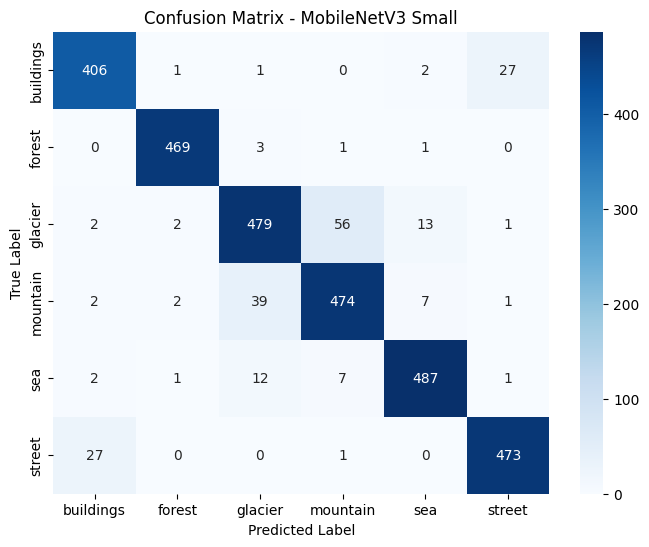


--- Mengevaluasi MobileNetV3 Large ---
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.9441 - loss: 0.2145
Test Loss (MobileNetV3 Large): 0.2376
Test Accuracy (MobileNetV3 Large): 0.9363
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step

Laporan Klasifikasi untuk MobileNetV3 Large:
              precision    recall  f1-score   support

   buildings       0.92      0.95      0.94       437
      forest       0.98      0.99      0.99       474
     glacier       0.92      0.88      0.90       553
    mountain       0.90      0.89      0.90       525
         sea       0.95      0.98      0.96       510
      street       0.95      0.94      0.94       501

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



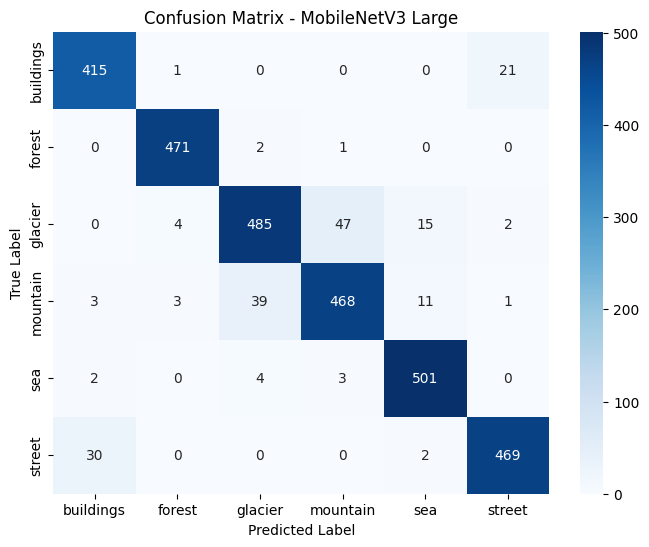

In [22]:
# Evaluasi kedua model
y_true_small, y_pred_proba_small, class_labels_small = evaluate_model(best_small_model, GRAPH_BASELINE_DIR, "MobileNetV3 Small")
y_true_large, y_pred_proba_large, class_labels_large = evaluate_model(best_large_model, GRAPH_BASELINE_DIR, "MobileNetV3 Large")

In [23]:
# --- Implementasi Grad-CAM ---
def get_img_array(img_path, size):
    img = tf.keras.utils.load_img(img_path, target_size=size)
    array = tf.keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0) 
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap * alpha + img.astype(np.uint8) * (1-alpha)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)


    plt.imshow(superimposed_img)
    plt.axis('off')

In [21]:
last_conv_layer_name_small = "activation_17"
last_conv_layer_name_large = "activation_37"

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Menampilkan Grad-CAM untuk MobileNetV3 Small (activation_17):


/home/abiyamf/anaconda3/envs/PCDL_env/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


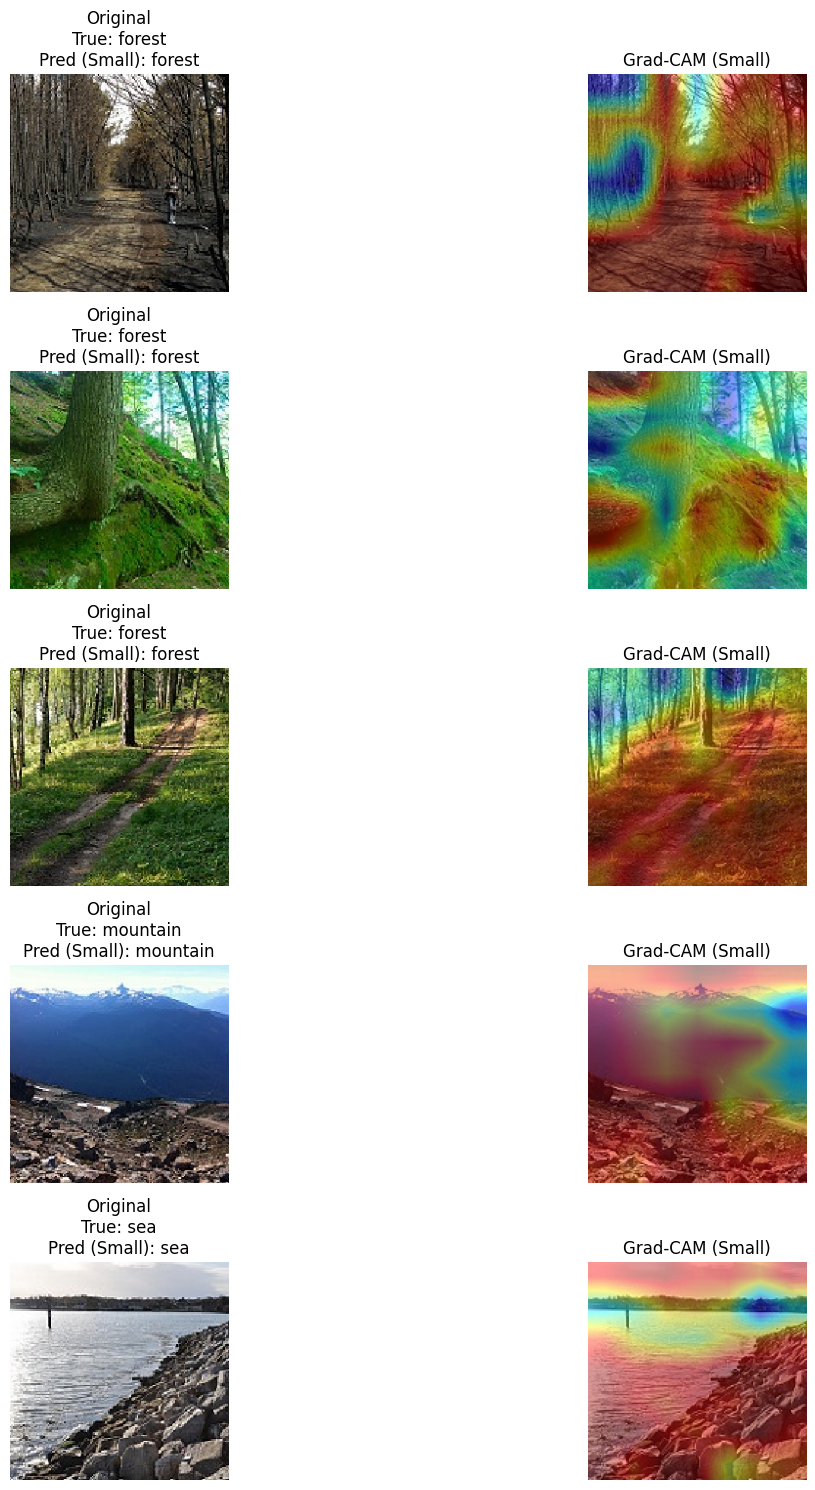


Menampilkan Grad-CAM untuk MobileNetV3 Large (activation_37):


/home/abiyamf/anaconda3/envs/PCDL_env/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


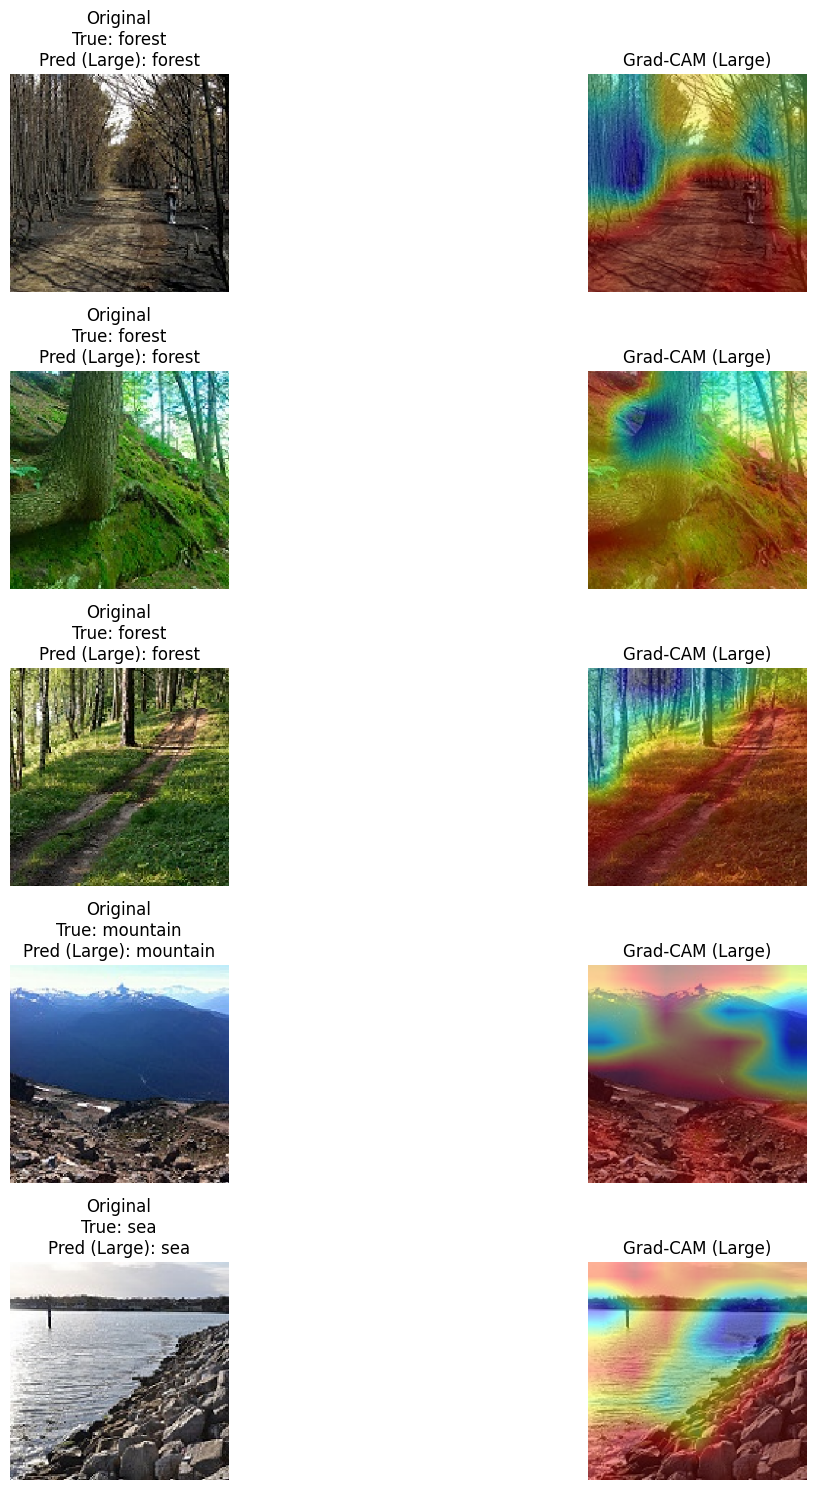


Analisis Kesalahan (Contoh):
Jumlah kesalahan (Small): 212 dari 3000
Contoh beberapa gambar yang salah diklasifikasikan oleh MobileNetV3 Small:


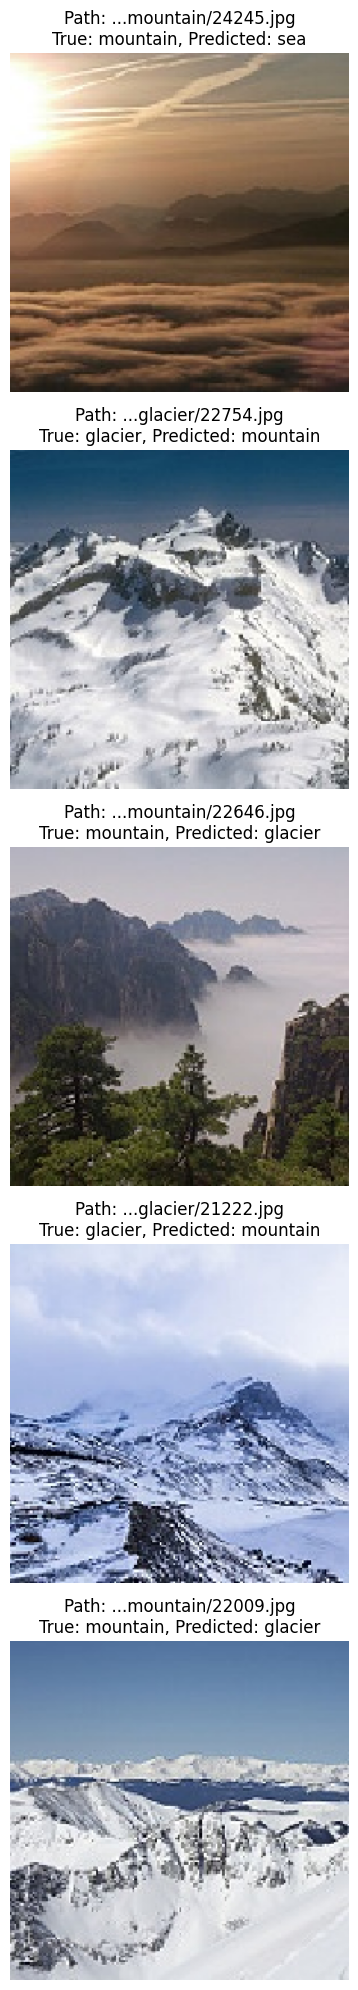


Tahap 5 Selesai.


In [22]:
num_gradcam_samples = 5
test_image_paths = []
test_image_labels_true = []
test_image_pred_labels_small = []
test_image_pred_labels_large = []

sample_indices = np.random.choice(len(test_generator.filenames), num_gradcam_samples, replace=False)

for i in sample_indices:
    img_path = os.path.join(TEST_DIR, test_generator.filenames[i])
    test_image_paths.append(img_path)
    test_image_labels_true.append(test_generator.classes[i])
    
    img_arr_processed = mobilenet_v3_preprocess_input(get_img_array(img_path, size=(IMG_WIDTH, IMG_HEIGHT)))
    
    pred_small_proba = best_small_model.predict(img_arr_processed)
    test_image_pred_labels_small.append(np.argmax(pred_small_proba[0]))
    
    pred_large_proba = best_large_model.predict(img_arr_processed)
    test_image_pred_labels_large.append(np.argmax(pred_large_proba[0]))


print(f"\nMenampilkan Grad-CAM untuk MobileNetV3 Small ({last_conv_layer_name_small}):")
plt.figure(figsize=(15, 3 * num_gradcam_samples))
for i, img_path in enumerate(test_image_paths):
    img_array_original = get_img_array(img_path, size=(IMG_WIDTH, IMG_HEIGHT))
    img_array_processed = mobilenet_v3_preprocess_input(np.copy(img_array_original))

    heatmap_small = make_gradcam_heatmap(img_array_processed, best_small_model, last_conv_layer_name_small, pred_index=test_image_pred_labels_small[i])
    
    plt.subplot(num_gradcam_samples, 2, 2 * i + 1)
    original_img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(original_img)
    true_label_name = class_labels_small[test_image_labels_true[i]]
    pred_label_name_small = class_labels_small[test_image_pred_labels_small[i]]
    plt.title(f"Original\nTrue: {true_label_name}\nPred (Small): {pred_label_name_small}")
    plt.axis('off')

    plt.subplot(num_gradcam_samples, 2, 2 * i + 2)
    display_gradcam(img_path, heatmap_small)
    plt.title(f"Grad-CAM (Small)")
    plt.axis('off')
plt.tight_layout()
plt.show()


print(f"\nMenampilkan Grad-CAM untuk MobileNetV3 Large ({last_conv_layer_name_large}):")
plt.figure(figsize=(15, 3 * num_gradcam_samples))
for i, img_path in enumerate(test_image_paths):
    img_array_original = get_img_array(img_path, size=(IMG_WIDTH, IMG_HEIGHT))
    img_array_processed = mobilenet_v3_preprocess_input(np.copy(img_array_original))

    heatmap_large = make_gradcam_heatmap(img_array_processed, best_large_model, last_conv_layer_name_large, pred_index=test_image_pred_labels_large[i])
    
    plt.subplot(num_gradcam_samples, 2, 2 * i + 1)
    original_img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(original_img)
    true_label_name = class_labels_large[test_image_labels_true[i]]
    pred_label_name_large = class_labels_large[test_image_pred_labels_large[i]]
    plt.title(f"Original\nTrue: {true_label_name}\nPred (Large): {pred_label_name_large}")
    plt.axis('off')

    plt.subplot(num_gradcam_samples, 2, 2 * i + 2)
    display_gradcam(img_path, heatmap_large)
    plt.title(f"Grad-CAM (Large)")
    plt.axis('off')
plt.tight_layout()
plt.show()

print("\nAnalisis Kesalahan:")
errors_small_indices = np.where(y_pred_proba_small.argmax(axis=1) != y_true_small)[0]
print(f"Jumlah kesalahan (Small): {len(errors_small_indices)} dari {len(y_true_small)}")

if len(errors_small_indices) > 0:
    print("Contoh beberapa gambar yang salah diklasifikasikan oleh MobileNetV3 Small:")
    num_error_samples_to_show = min(5, len(errors_small_indices))
    random_error_indices = np.random.choice(errors_small_indices, num_error_samples_to_show, replace=False)
    
    plt.figure(figsize=(15, 4 * num_error_samples_to_show))
    for i, error_idx in enumerate(random_error_indices):
        img_path = os.path.join(TEST_DIR, test_generator.filenames[error_idx])
        original_img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
        
        true_label_name = class_labels_small[y_true_small[error_idx]]
        pred_label_name = class_labels_small[y_pred_proba_small.argmax(axis=1)[error_idx]]
        
        plt.subplot(num_error_samples_to_show, 1, i + 1)
        plt.imshow(original_img)
        plt.title(f"Path: ...{test_generator.filenames[error_idx][-30:]}\nTrue: {true_label_name}, Predicted: {pred_label_name}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nTahap 5 Selesai.")